In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

### Stock to test the support and resistance
* kweb
* yinn
* xbtf

[*********************100%***********************]  1 of 1 completed


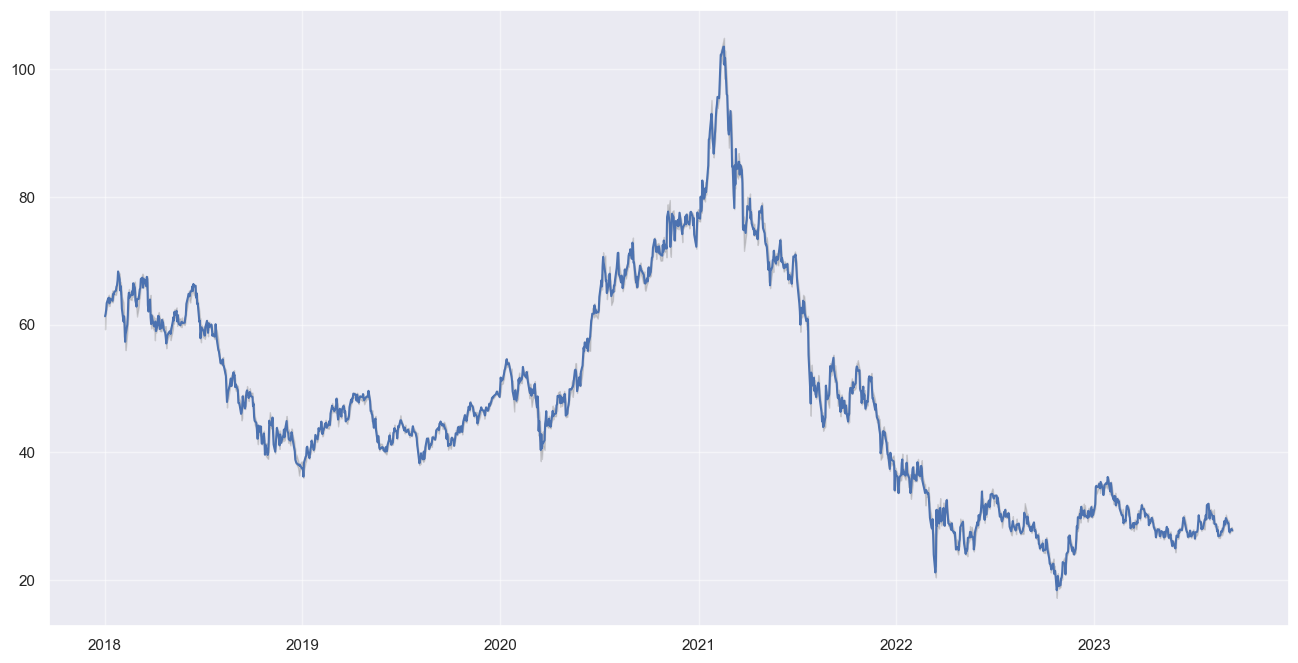

In [2]:
df_kweb = yf.download('kweb'.upper(), start='2018-01-01', end=datetime.today().strftime('%Y-%m-%d'))
df_kweb = df_kweb.reset_index()

plt.figure(figsize=(16, 8))
plt.grid(True, alpha=0.5)

plt.plot(df_kweb['Date'], df_kweb['Close'], label='Daily Close Price')
# plt.plot(df_kweb['Date'], df_kweb['High'], color='green', label='Highest Price')
# plt.plot(df_kweb['Date'], df_kweb['Low'], color='red', label='Lowest Price')

# Shading the region between the highest and lowest prices
plt.fill_between(df_kweb['Date'], df_kweb['Low'], df_kweb['High'], color='gray', alpha=0.3, label='Daily Price Range')
plt.show()

In [3]:
df_kweb.columns = df_kweb.columns.str.lower()
df_kweb.head()


,date,open,high,low,close,adj close,volume
0,2018-01-02,59.279999,61.369999,59.279999,61.320000,55.018791,780100
1,2018-01-03,61.849998,61.930000,61.369999,61.689999,55.350765,604500
2,2018-01-04,62.250000,62.610001,61.919998,62.279999,55.880138,629100
3,2018-01-05,62.610001,63.400002,62.580002,63.389999,56.876076,530300
4,2018-01-08,63.439999,64.250000,63.410000,64.150002,57.557980,945500


In [4]:
df2 = pd.DataFrame()

# Number of previous days to include
num_prev_days = 10

# Loop through the dates in df_kweb
for i, row in df_kweb[df_kweb['date']>='2023-07-01'].iterrows():
    date = row['date']
    price = row['close']
    
    # Create columns for each previous day's price
    for day in range(num_prev_days):
        prev_date = date - pd.Timedelta(days=day + 1)
        prev_price = df_kweb.loc[df_kweb['date'] == prev_date, 'close'].values
        
        # Add the previous day's price to the new dataframe
        col_name = f'price_{-day - 1}day'
        df2.at[i, col_name] = prev_price[0] if len(prev_price) > 0 else None
    
    # Add the current day's price to the new dataframe
    df2.at[i, 'price_0day'] = price

# Merge the date column from df_kweb with df2
df2['date'] = df_kweb[df_kweb['date']>='2023-07-01']['date']

# Reorder the columns to have 'date' first
column_order = ['date'] + [f'price_{-day}day' for day in range(num_prev_days)]
df2 = df2[column_order]

print(df2)

           date  price_0day  price_-1day  price_-2day  price_-3day   
1383 2023-07-03   27.570000          NaN          NaN    26.930000  \
1384 2023-07-05   27.350000          NaN    27.570000          NaN   
1385 2023-07-06   26.490000    27.350000          NaN    27.570000   
1386 2023-07-07   27.480000    26.490000    27.350000          NaN   
1387 2023-07-10   27.559999          NaN          NaN    27.480000   
1388 2023-07-11   27.930000    27.559999          NaN          NaN   
1389 2023-07-12   29.129999    27.930000    27.559999          NaN   
1390 2023-07-13   30.150000    29.129999    27.930000    27.559999   
1391 2023-07-14   29.250000    30.150000    29.129999    27.930000   
1392 2023-07-17   29.080000          NaN          NaN    29.250000   
1393 2023-07-18   27.959999    29.080000          NaN          NaN   
1394 2023-07-19   28.290001    27.959999    29.080000          NaN   
1395 2023-07-20   28.070000    28.290001    27.959999    29.080000   
1396 2023-07-21   28

In [5]:
df2.head()

,date,price_0day,price_-1day,price_-2day,price_-3day,price_-4day,price_-5day,price_-6day,price_-7day,price_-8day,price_-9day
1383,2023-07-03,27.570000,NaN,NaN,26.93,26.83,27.40,27.75,26.889999,NaN,NaN
1384,2023-07-05,27.350000,NaN,27.57,NaN,NaN,26.93,26.83,27.400000,27.75,26.889999
1385,2023-07-06,26.490000,27.35,NaN,27.57,NaN,NaN,26.93,26.830000,27.40,27.750000
1386,2023-07-07,27.480000,26.49,27.35,NaN,27.57,NaN,NaN,26.930000,26.83,27.400000
1387,2023-07-10,27.559999,NaN,NaN,27.48,26.49,27.35,NaN,27.570000,NaN,NaN


[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'yinn')

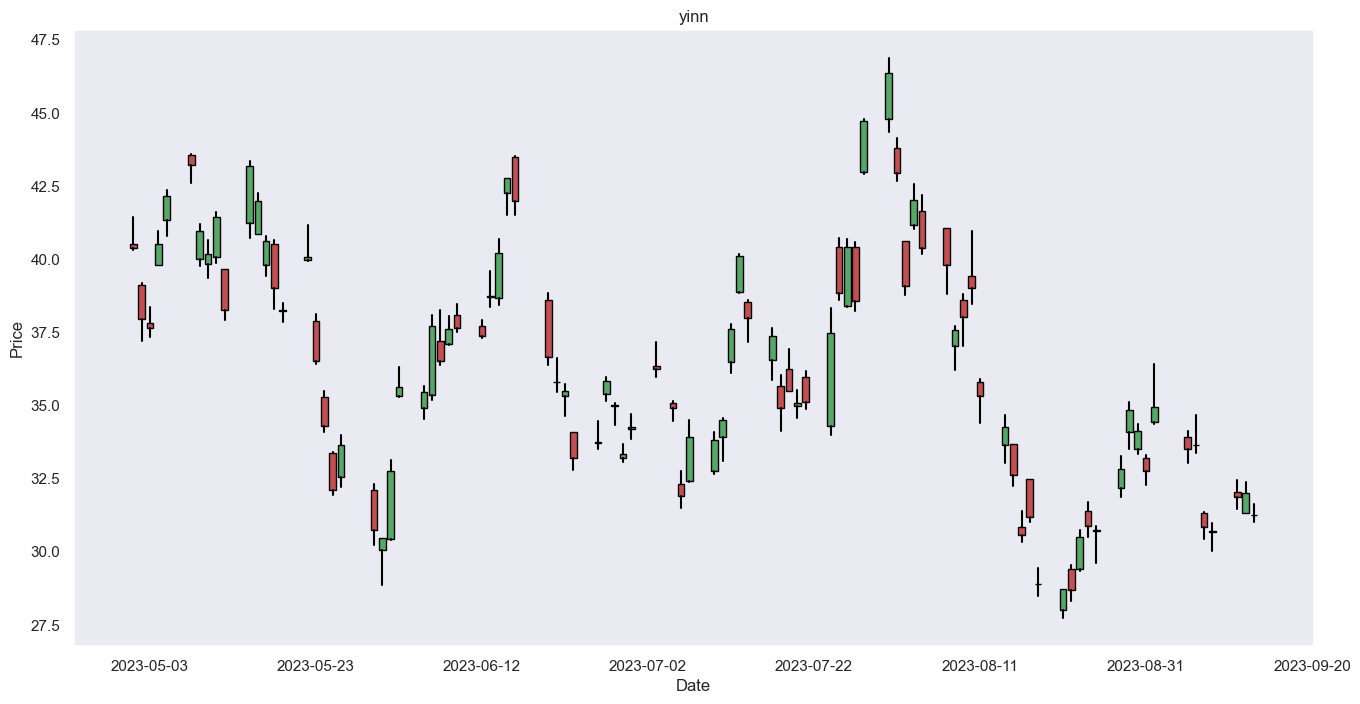

In [6]:
df_yinn = yf.download('yinn'.upper(), start='2023-05-01', end=datetime.today().strftime('%Y-%m-%d'))
df_yinn = df_yinn.reset_index()

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')

In [22]:
lows = df_yinn[['Date',"Low"]].set_index('Date')
highs = df_yinn[['Date',"High"]].set_index('Date')

In [23]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

Optimum K is 10
Optimum K is 10
[[28.34749985]
 [30.11500025]
 [31.75727272]
 [33.27916654]
 [34.73533351]
 [36.71500043]
 [38.41833305]
 [39.82999945]
 [41.06499926]
 [43.13999844]]
[[29.24666659]
 [31.14999986]
 [32.99363674]
 [34.54571451]
 [36.15000006]
 [38.29437518]
 [40.6400001 ]
 [42.17714255]
 [43.88199921]
 [46.86999893]]


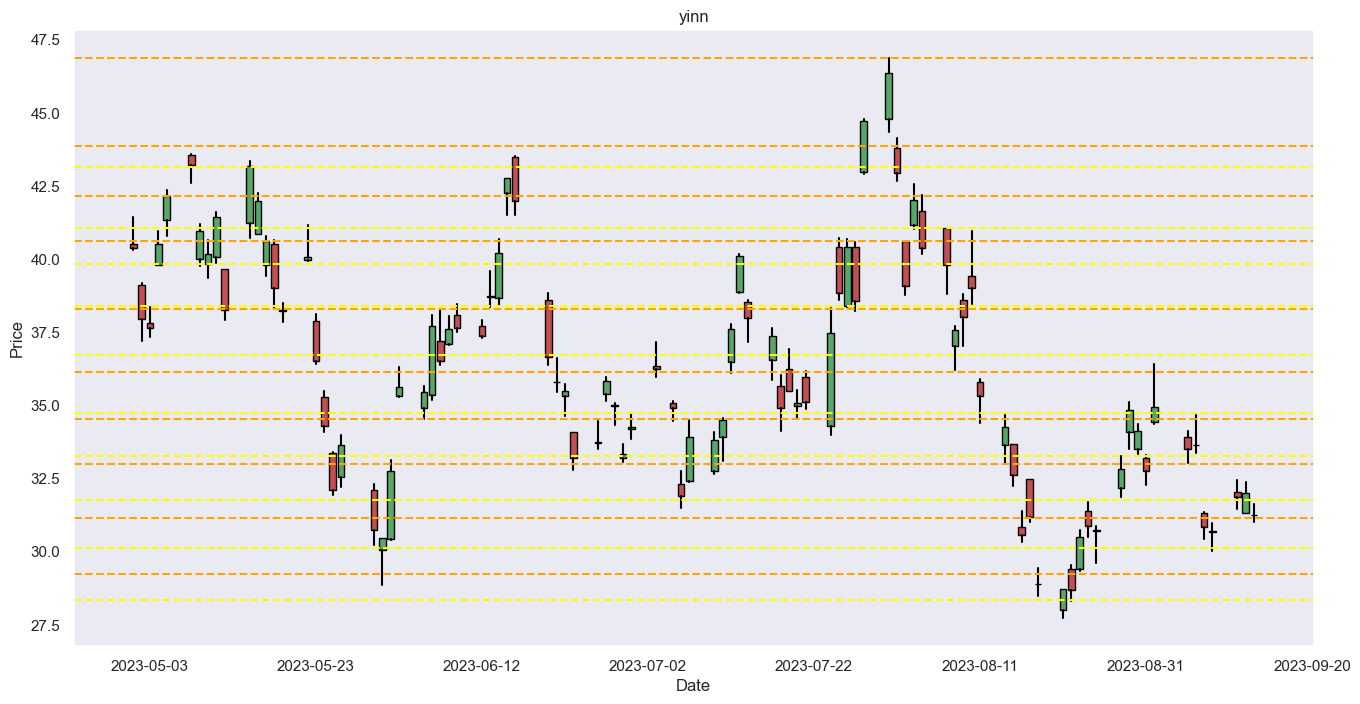

In [24]:
low_clusters = get_optimum_clusters(lows)
low_centers = low_clusters.cluster_centers_
low_centers = np.sort(low_centers, axis=0)

high_clusters = get_optimum_clusters(highs)
high_centers = high_clusters.cluster_centers_
high_centers = np.sort(high_centers, axis=0)

print(low_centers)
print(high_centers)

ax = plot_candlestick(df_yinn)
ax.set_title('yinn')
for low in low_centers[:]:
    ax.axhline(low[0], color='yellow', ls='--')

for high in high_centers[:]:
    ax.axhline(high[0], color='orange', ls='--')
